In [20]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
from os.path import join as oj
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
import matching
from tqdm import tqdm
from collections import OrderedDict
from config import *
from style import cb, cr, cg, cp
import data
import scipy.stats
import util
import viz

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')

# add Race = Black
k_group = 'gender'
df['Race=Black'] = 0
df.loc[df['race4_pred'] == 'Black', 'Race=Black'] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# fit propensity scores
**matching code based on [here](https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb)**

In [7]:
# add latent dims
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
latents = np.array([np.load(oj(DIR_GEN, f))
                    for f in fname_nps]).mean(axis=1) # restricted style space

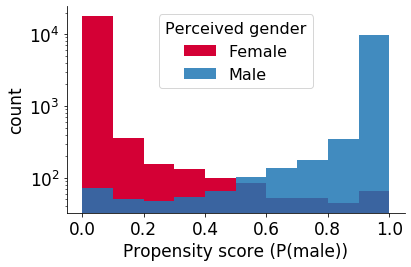

In [17]:
lm = LogisticRegression()
lm = lm.fit(latents, df['gender']) #data[names[1:-1]], data.Treated)
pscores = lm.predict_proba(latents)[:, 1] # The predicted propensities by the model
plt.hist(pscores[df['gender'] == 0], label='Female', color=cr)
plt.hist(pscores[df['gender'] == 1], label='Male', alpha=0.85, color=cb)
df['pscores'] = pscores
plt.xlabel('Propensity score (P(male))')
plt.ylabel('count')
plt.yscale('log')
plt.legend(title='Perceived gender')
util.savefig('scores_propensity')
plt.show()

In [9]:
d = df.reset_index()
matches1, matches2 = matching.calc_propensity_matches(d['gender'], d['pscores'], caliper=0.05)

df_matched = d.loc[matches1 + matches2]
df_matched['gender'].sum()

  0%|          | 42/10914 [00:00<00:26, 415.41it/s]

need to flip!


100%|██████████| 10914/10914 [00:09<00:00, 1137.07it/s]


593

# mean diff checking

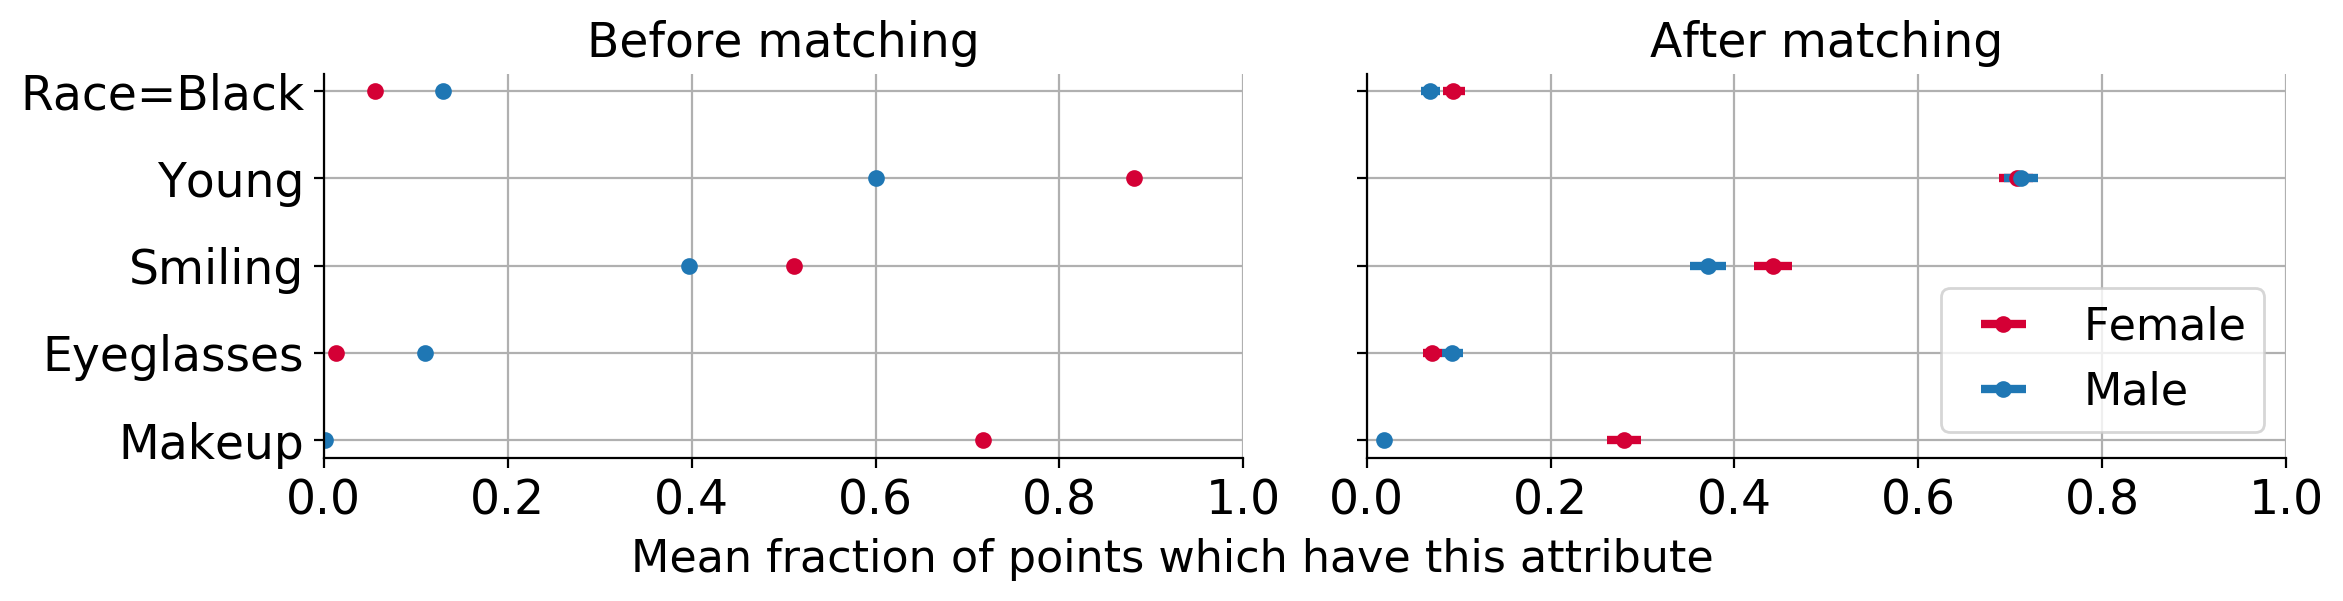

In [41]:
ds = [df, df_matched]
ks = [ #'yaw', 'pitch', 'roll',
         'Race=Black', 'young', 'smiling',
          'eyeglasses', 'makeup', 'gender',
          ][::-1] #, 'background_mean']
viz.plot_subgroup_mean_diffs(ds, ks, k_group)
plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('means_matching_propensity')
plt.show()

# intersectional mean diffs
**means across different intersectional subgroups**

<Figure size 2800x2200 with 0 Axes>

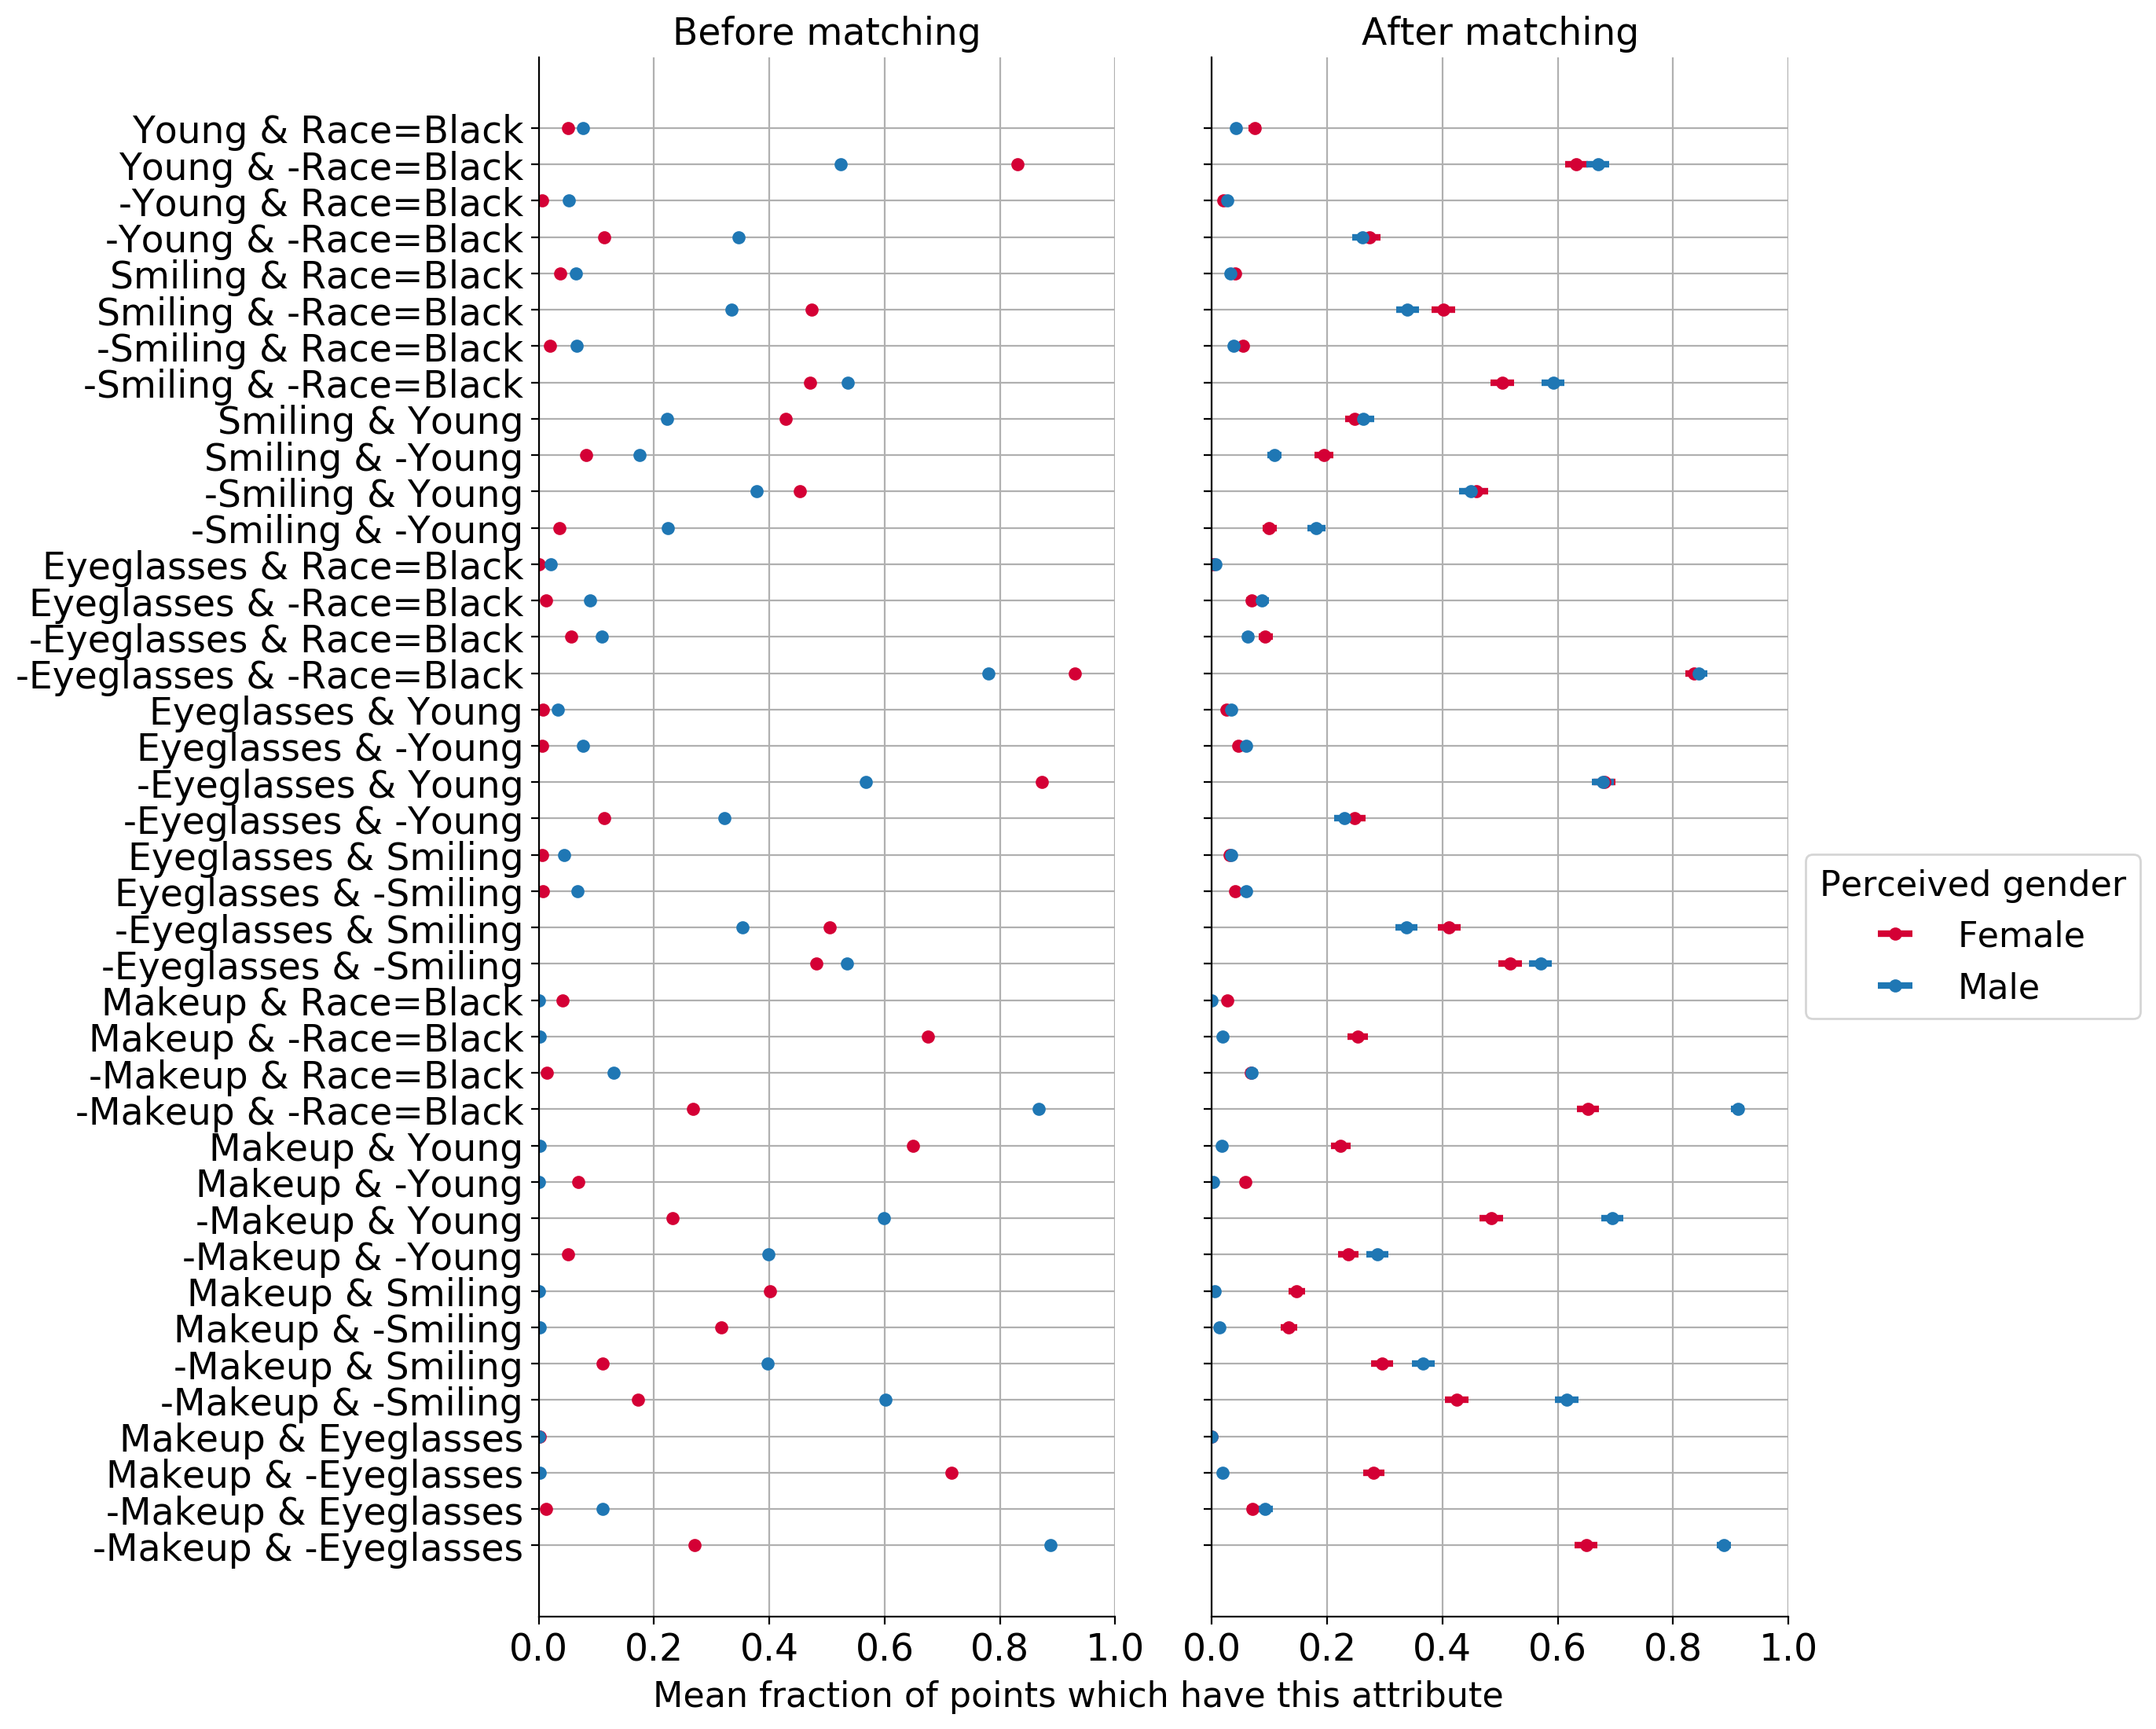

In [42]:
R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(14, 11))
ks_init = ['Race=Black', 'young', 'smiling', 'eyeglasses', 'makeup', 'gender']
df_int, ks = matching.add_intersections(df, ks_init)
df_matched_int, ks = matching.add_intersections(df_matched, ks_init)
ds = [df_int, df_matched_int]
ks = ks[::-1] + ['gender']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, figsize=(14, 11))


util.savefig('means_intersectional_matching_propensity')
plt.show()